In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics

In [40]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config = {
    'domain': {
        'minExtent': -L,
        'maxExtent': L,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': nx
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : u_mag * 10
    },
    'shifting':{
        'scheme': 'deltaSPH',
        'threshold': 0.05,
        'maxIterations': 1,
        'freeSurface': False
    },
    'timestep':{
        'dt':0.001,
        'active':False,
        'minDt':1e-6,
    },
    'sps':{
        'active': True
    },
    'noise':{
    #     'n': nx,
        'baseFrequency': 1,
    #     'dim': 2,
        'octaves': 1,
    #     'persistence': 0.5,
    #     'lacunarity': 2,
    #     'seed': 23467586,
    #     'tileable': True,
    #     'kind': 'simplex',
    },
    'diffusion':{
        'velocityScheme': 'deltaSPH_inviscid',
        'alpha': 0.010793905705213547
    },
    'plot':{
        # 'mosaic': '''A''',
    #     'figSize': (6,5.5),
        'plots': {'A': {'val': 'index', 'cbar': True, 'cmap': 'twilight', 'scale': 'lin', 'size': 1, 'gridVis' : False, 'title': 'Fluid Index'}},
    #     'export': True,
        'updateInterval': 32*3,
    #     'namingScheme': 'timestep',
    #     'exportPath': 'output',
    #     'gif': True,
        'fps': 30,
    },
    'export':{
        'active': False,
    #     'path': 'export',
    #     'namingScheme': 'timestep',
    #     'interval': 1,
    },
    'boundary':{
        'active':False
    },
    # 'simulation':{'timestamp': datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

if config['diffusion']['velocityScheme'] == 'deltaSPH_inviscid':
    nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support']   / (2 * (config['domain']['dim'] + 2)) * 5/4
    Re = u_mag * (2 * L) / config['diffusion']['nu_sph']

    target_nu = u_mag * (2 * L) / targetRe
    alpha = target_nu / (config['fluid']['cs'] * config['particle']['support']  / (2 * (config['domain']['dim'] + 2)) * 5/4) #/ config['kernel']['kernelScale']
    config['diffusion']['alpha'] = alpha
    # print(alpha)
    if alpha < 0.01:
        print(rf'$\alpha = {alpha}$ is very low, consider increasing the value (should be > 0.01)')
elif config['diffusion']['velocityScheme'] == 'deltaSPH_viscid':
    nu_sph = config['diffusion']['nu']
    Re = u_mag * (2 * L) / config['diffusion']['nu']
    target_nu = u_mag * (2 * L) / targetRe
    config['diffusion']['nu'] = target_nu


config['diffusion']['nu_sph'] = computeViscosityParameter(None, config)# * config['kernel']['kernelScale']
config['diffusion']['Re'] = u_mag * (2 * L) / config['diffusion']['nu_sph']

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$')
config['simulation']['correctArea'] = True
# display(config)

Re = 1999.9998779296875, $\nu_{sph} = 0.0020000000949949026$


In [41]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict
TGV_override = False

ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
# plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = [], randomizeParticles=False)

priorState = None
TGV_override = False
if TGV_override:
    k = 1 * np.pi
    particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
    particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# omega = 4

# k = np.pi

u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
particleState['velocities'] = particleState['velocities'] / u_max * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

targetEK = 3000
ratio = np.sqrt(targetEK / Ek0.detach().sum().cpu().item())
# print(f'ratio: {ratio}')
particleState['velocities'] = particleState['velocities'] * ratio

initialVelocities = particleState['velocities'].clone()


particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

perennialState = {
    'fluid': copy.deepcopy(particleState),
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}
# del particleState['neighborhood']


E_k0 = 3000, E_k = 3000, rel. diff = 0.00%, Re = nan


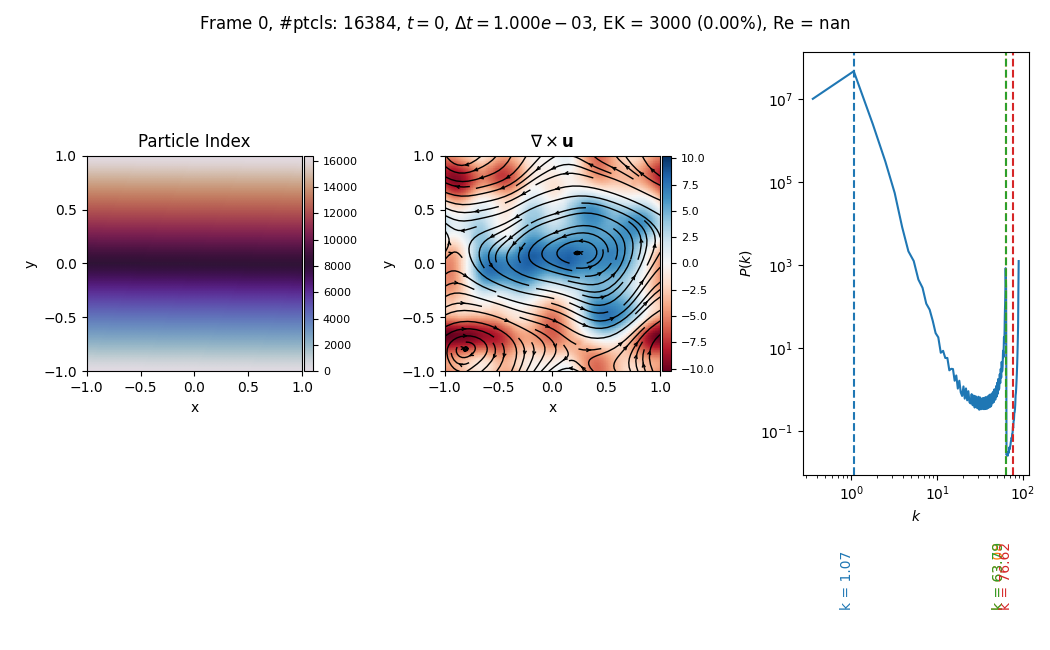

In [42]:
from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid
from diffSPH.v2.sphOps import sphOperationStates

s = 1

fig, axis = plt.subplot_mosaic('''ACB''', figsize=(10.5,6.5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = perennialState['fluid']['index']
plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['A'].set_title(r'Particle Index')

# plotDensityIndex = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidDensities'] , cbar = True, cmap = 'Spectral_r', scaling = 'sym', midPoint = config['fluid']['rho0'], gridVisualization= False, s = s, mapping = '.x')
# axis['B'].set_title(r'$\rho$')

curl = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'curl', gradientMode = 'difference', neighborhood = perennialState['fluid']['neighborhood'])
plotVelocityMagIndex = visualizeParticles(fig, axis['C'], config, visualizationState, curl, s = s, cmap = 'RdBu', scaling = 'sym', midPoint = 0, gridVisualization= False, mapping = '.x')
axis['C'].set_title(r'$\nabla \times \mathbf{u}$')

# plotVelocityMagIndex = visualizeParticles(fig, axis['C'], config, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1) , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
# axis['C'].set_title(r'$|\mathbf{u}|$')

grid_ux = mapToGrid(visualizationState, perennialState['fluid']['velocities'][:,0])
grid_uy = mapToGrid(visualizationState, perennialState['fluid']['velocities'][:,1])
X = visualizationState['X']
Y = visualizationState['Y']

stream = axis['C'].streamplot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), grid_ux.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), grid_uy.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), color='k', linewidth=1, density=1, arrowstyle='->', arrowsize=0.5)

data = torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)
visualizationState, physical_freqs_xx, physical_freqs_yy, fft_mag, kvals, Abins, peaks = computePSD(perennialState, data, config, nGrid = 255)

# plotVelMagIndex = visualizeParticles(fig, axis['A'], config, visualizationState, data, cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
# plotFFT(fig, axis['B'], physical_freqs_xx, physical_freqs_yy, fft_mag)
plotPSD(fig, axis['B'], kvals, Abins, peaks = peaks)



E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()

E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

print(f'E_k0 = {E_k0:.4g}, E_k = {E_k:.4g}, rel. diff = {(E_k - E_k0)/E_k0:.2%}, Re = {Re:.4g}')

# config['timestep']['dt'] = 0.003

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState['fluid']["numParticles"]}, $t = {perennialState["time"] :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$, EK = {E_k:.4g} ({(E_k - E_k0)/E_k0:.2%}), Re = {Re:.6g}''')

# axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
# axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)

fig.tight_layout()
del visualizationState


In [43]:
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

In [44]:
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.plotting import visualizeParticleQuantity

In [45]:
simulationState = copy.deepcopy(initialState)

simulationState['fluid']['densities'], _ = callModule(simulationState, computeDensity, config, 'fluid')
simulationState['fluid']['velocityDiffusion'], _ = callModule(simulationState, computeViscosity, config, 'fluid')
simulationState['fluid']['gravityAccel'] = computeGravity(simulationState['fluid'], config)


In [47]:
simulationState['fluid']['velocities']

tensor([[-0.2681,  0.4723],
        [-0.2656,  0.4225],
        [-0.2634,  0.3712],
        ...,
        [-0.3078,  0.6101],
        [-0.3038,  0.5686],
        [-0.2997,  0.5236]], device='cuda:0')

In [48]:
from diffSPH.v2.modules.dfsph import dfsphSolve

In [49]:
perennialState = copy.deepcopy(simulationState)

In [50]:
config['timestep']['dt'], perennialState['dt']

(0.001, 0.001)

In [51]:
perennialState['fluid']['neighborhood'] = neighborSearch(perennialState['fluid'],perennialState['fluid'], config)
perennialState['fluid']['densities'], _ = callModule(perennialState, computeDensity, config, 'fluid')
errors, pressures, pressureAccel, pressure = dfsphSolve(perennialState, config)

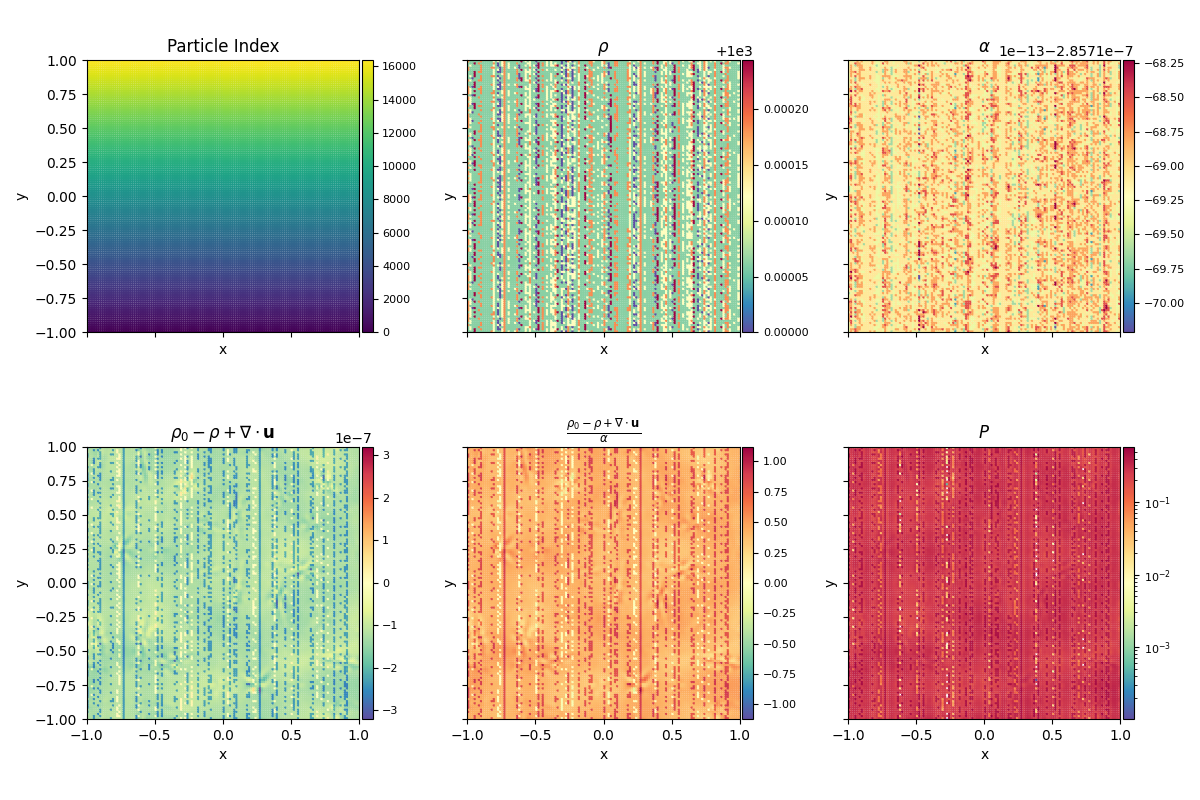

In [52]:
fig, axis = plt.subplots(2,3, figsize = (12,8), sharex=True, sharey=True, squeeze=False)
visualizationState = prepVisualizationState(perennialState, config)

plotIndexState = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, 'index', cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis[0,0].set_title(r'Particle Index')

plotDensityState = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, 'densities', cbar = True, cmap = 'Spectral_r', scaling = 'lin', midPoint = config['fluid']['rho0'], gridVisualization= False, s = s, mapping = '.x')
axis[0,1].set_title(r'$\rho$')

plotAlphaState = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, 'alpha', cbar = True, cmap = 'Spectral_r', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis[0,2].set_title(r'$\alpha$')

plotSourceState = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, 'sourceTerm', cbar = True, cmap = 'Spectral_r', scaling = 'sym', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis[1,0].set_title(r'$\rho_0 - \rho + \nabla \cdot \mathbf{u}$')

plotSourceState = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, perennialState['fluid']['sourceTerm'] / perennialState['fluid']['alpha'], cbar = True, cmap = 'Spectral_r', scaling = 'sym', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis[1,1].set_title(r'$\frac{\rho_0 - \rho + \nabla \cdot \mathbf{u}}{\alpha}$')

plotPressureState = visualizeParticleQuantity(fig, axis[1,2], config, visualizationState, 'pressureB', cbar = True, cmap = 'Spectral_r', scaling = 'log', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis[1,2].set_title(r'$P$')

fig.tight_layout()

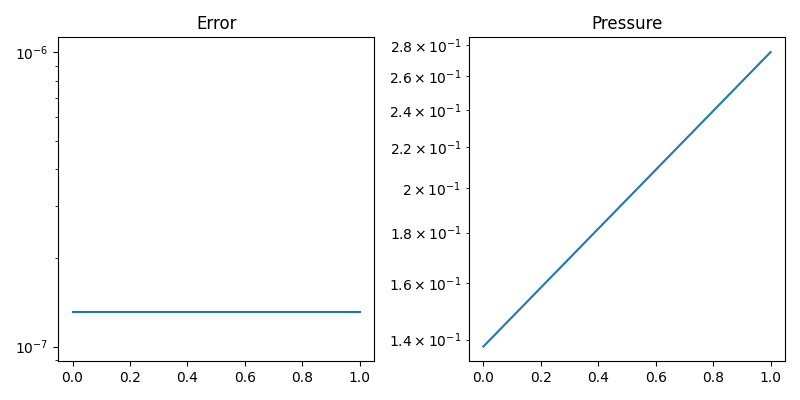

In [53]:
fig, axis = plt.subplots(1,2, figsize = (8,4), sharex=True, sharey=False, squeeze=False)

axis[0,0].plot(errors)
axis[0,0].set_title('Error')
axis[0,0].set_yscale('log')

axis[0,1].plot(pressures)
axis[0,1].set_title('Pressure')
axis[0,1].set_yscale('log')

fig.tight_layout()

In [54]:
errors, pressures, pressureAccel, pressure = dfsphSolve(simulationState, config)


In [55]:
config['integration']['scheme'] = 'RK4'

In [61]:
from diffSPH.v2.simulationSchemes.dfsph import dfsphSimulationStep

ImportError: cannot import name 'dfsphSimulationStep' from 'diffSPH.v2.simulationSchemes.dfsph' (/home/winchenbach/dev/diffSPH/src/diffSPH/v2/simulationSchemes/dfsph.py)

0.0000%|          | 0/1 [00:00<?] ?it/s

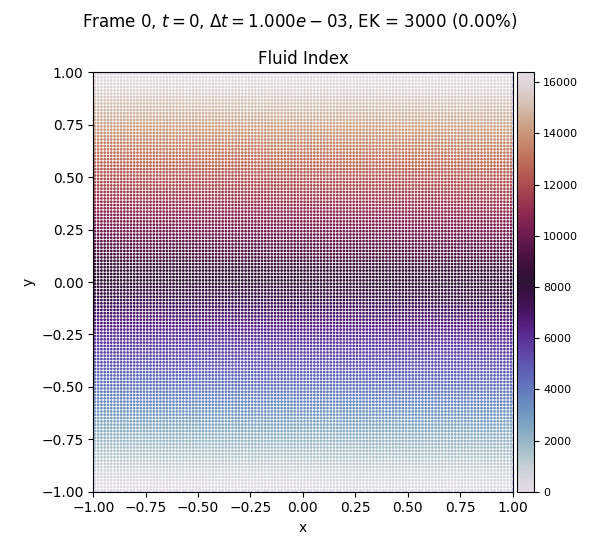

In [62]:
from diffSPH.v2.runner import runSimulation, setupSimulation, updatePlots
perennialState, fig, axis, plotStates, priorState, pbar, stats = setupSimulation(initialState, config, stepLimit = -1, timeLimit = 1)

In [63]:
stat, pstate = runSimulation(fig, axis, dfsphSimulationStep, plotStates, priorState, pbar, stats, perennialState, simulationState, config, stepLimit = -1, timeLimit = 1)

  0:   2 iters -> +1.3081e-07, pressure mean: +2.7501e-01
  0:   2 iters -> +1.2567e-07, pressure mean: +7.7330e+00
  0:   2 iters -> +1.2635e-07, pressure mean: +7.5317e+00
  0:   2 iters -> +6.1577e-08, pressure mean: +1.7669e+01
  1:   2 iters -> +6.1275e-08, pressure mean: +1.7528e+01
  1:   2 iters -> -1.5916e-08, pressure mean: +3.0429e+01
  1:   2 iters -> -1.4485e-08, pressure mean: +2.9966e+01
  1:   2 iters -> -1.0833e-07, pressure mean: +4.5136e+01
  2:   2 iters -> -1.1159e-07, pressure mean: +4.4678e+01
  2:   2 iters -> -2.1405e-07, pressure mean: +6.2383e+01
  2:   2 iters -> -2.1713e-07, pressure mean: +6.1627e+01
  2:   2 iters -> -3.3506e-07, pressure mean: +8.1249e+01
  3:   2 iters -> -3.3246e-07, pressure mean: +8.0270e+01
  3:   2 iters -> -4.6817e-07, pressure mean: +1.0221e+02
  3:   2 iters -> -4.6708e-07, pressure mean: +1.0115e+02
  3:   2 iters -> -6.1232e-07, pressure mean: +1.2468e+02
  4:   2 iters -> -6.1424e-07, pressure mean: +1.2296e+02
  4:   2 iters

In [229]:
perennialState = copy.deepcopy(simulationState)
# display(perennialState)

In [230]:
for i in range(128):
    perennialState, priorState, *updates = integrate(dfsphSimulationStep, perennialState, config, previousStep= priorState)
    # Particle shifting
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'] += dx
    # Frame done, update state for next timestep
    perennialState['dt'] = config['timestep']['dt']
    perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
    perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
    frameStatistics = computeStatistics(perennialState, particleState, config)

    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1

    config['timestep']['dt'] = computeTimestep(perennialState, config)
    updatePlots(perennialState, simulationState, config, plotStates, fig, axis)

  0:   2 iters -> +1.3139e-07, pressure mean: +2.7594e+05
  0:   2 iters -> +1.3632e-07, pressure mean: +4.8411e+05
  0:   2 iters -> +1.3637e-07, pressure mean: +4.0996e+05
  0:   2 iters -> +1.5078e-07, pressure mean: +6.2023e+05
  1:   2 iters -> +1.5390e-07, pressure mean: +2.6208e+03
  1:   2 iters -> +1.8148e-07, pressure mean: +3.1956e+03
  1:   2 iters -> +1.8056e-07, pressure mean: +2.7137e+03
  1:   2 iters -> +1.8240e-07, pressure mean: +2.9982e+03
  2:   2 iters -> +1.8252e-07, pressure mean: +1.4645e+02
  2:   2 iters -> +1.6790e-07, pressure mean: +1.8905e+02
  2:   2 iters -> +1.6857e-07, pressure mean: +1.7241e+02
  2:   2 iters -> +1.5688e-07, pressure mean: +2.0243e+02
  3:   2 iters -> +1.4350e-07, pressure mean: +1.7807e+01
  3:   2 iters -> +3.0402e-07, pressure mean: +2.6974e+01
  3:   2 iters -> +2.7358e-07, pressure mean: +2.5428e+01
  3:   2 iters -> +8.7683e-07, pressure mean: +3.6657e+01
  4:   2 iters -> +4.3247e-07, pressure mean: +1.8881e+01
  4:   2 iters

In [ ]:
    def computeAlpha(self, simulationState, simulation, density = True):
        with record_function("DFSPH - alpha"): 
            kSum1, kSum2 = computeAlphaFluidTerm(simulationState['fluidArea'], simulationState['fluidRestDensity'], simulationState['fluidActualArea'], simulationState['fluidNeighbors'], simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
            if hasattr(simulation, 'boundaryModule') and simulation.boundaryModule.active:
                bdykSum1, bdykSum2 = simulation.boundaryModule.dfsphBoundaryAlphaTerm(simulationState, simulation, density)
                kSum1 += bdykSum1
                kSum2 += bdykSum2
            
            return computeAlphaFinal(kSum1, kSum2, simulationState['dt'], simulationState['fluidArea'], simulationState['fluidActualArea'], simulationState['fluidRestDensity'])
        


In [ ]:


                simulationState['fluidAlpha'] = self.computeAlpha(simulationState, simulation, density)

In [ ]:

    def densitySolve(self, simulationState, simulation):
        with record_function("DFSPH - densitySolve"): 
            errors = []
            i = 0
            error = 0.
            minIters = self.minDensitySolverIterations
#             minIters = 32
            if 'densityErrors' in simulationState:
                minIters = max(minIters, len(simulationState['densityErrors'])*0.75)

            while((i < minIters or \
                    error > self.densityThreshold) and \
                    i <= self.maxDensitySolverIterations):
                
                with record_function("DFSPH - densitySolve (iteration)"): 
                    with record_function("DFSPH - densitySolve (computeAccel)"): 
                        simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, True)
                        # simulation.sync(simulationState['fluidPredAccel'])
                        # simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
                        simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

                    with record_function("DFSPH - densitySolve (updatePressure)"): 
                        simulationState['fluidPressure2'], simulationState['residual'] = self.computeUpdatedPressure(simulationState, simulation, True)             
                        # simulation.sync(simulationState['fluidPressure2'])
                        # simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)
                        # debugPrint(self.boundaryScheme)
                        # debugPrint(self.pressureScheme)
                        if hasattr(simulation, 'boundaryModule') and simulation.boundaryModule.active and self.pressureScheme == 'PBSPH':
                            boundaryError = torch.sum(torch.clamp(simulation.boundaryModule.boundaryResidual, min = -self.densityThreshold))
                            fluidError = torch.sum(torch.clamp(simulationState['residual'], min = -self.densityThreshold))
                            error = (fluidError + boundaryError) / (simulation.boundaryModule.numPtcls + simulationState['residual'].shape[0])
                            # debugPrint(boundaryError)
                        else:
                            error = torch.mean(torch.clamp(simulationState['residual'], min = -self.densityThreshold))# * simulationState['fluidArea'])
                        
                    errors.append((error).item())
                    i = i + 1
            simulationState['densityErrors'] = errors
            simulationState['densitySolverPressure'] = simulationState['fluidPressure']
            return errors



    def computeSourceTerm(self, simulationState, simulation, density = True):
        with record_function("DFSPH - source"): 
            source = computeSourceTermFluid(simulationState['fluidActualArea'], simulationState['fluidPredictedVelocity'], simulationState['fluidNeighbors'], simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support, simulationState['dt'])
            if hasattr(simulation, 'boundaryModule') and simulation.boundaryModule.active:
                source = source + simulation.boundaryModule.dfsphBoundarySourceTerm(simulationState, simulation, density)

                                
            return 1. - simulationState['fluidDensity'] + source if density else source            
        
        
    def DFSPH(self, simulationState, simulation, density = True): 
        with record_function("DFSPH - solver"): 
            with record_function("DFSPH - predict velocity"): 
                simulationState['fluidPredAccel'] = torch.zeros(simulationState['fluidPosition'].shape, dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)
                simulationState['fluidPredictedVelocity'] = simulationState['fluidVelocity'] + simulationState['dt'] * simulationState['fluidAcceleration']
                simulationState['fluidActualArea'] = simulationState['fluidArea'] / simulationState['fluidDensity']

            with record_function("DFSPH - compute alpha"): 
                if hasattr(simulation, 'boundaryModule') and simulation.boundaryModule.active:
                    simulation.boundaryModule.dfsphPrepareSolver(simulationState, simulation, density)

                simulationState['fluidAlpha'] = self.computeAlpha(simulationState, simulation, density)
                # simulation.sync(simulationState['fluidAlpha'])
                # simulation.periodicBC.syncQuantity(simulationState['fluidAlpha'], simulationState, simulation)

            with record_function("DFSPH - compute source"):
                simulationState['fluidSourceTerm'] = self.computeSourceTerm(simulationState, simulation, density)
                # simulation.sync(simulationState['fluidSourceTerm'])
                # simulation.periodicBC.syncQuantity(simulationState['fluidSourceTerm'], simulationState, simulation)
                
            with record_function("DFSPH - initialize pressure"):
                simulationState['fluidPressure2'] =  torch.zeros(simulationState['numParticles'], dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)

                # if 'densitySolverPressure' in simulationState and density:
                    # simulationState['fluidPressure2'] =  simulationState['densitySolverPressure'] * 0.5
                # else:
                simulationState['fluidPressure2'] = torch.zeros(simulationState['numParticles'], dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)
                simulationState['fluidPressure'] = torch.zeros(simulationState['numParticles'], dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)
                
                # simulation.sync(simulationState['fluidPressure2'])
                # simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)
                totalArea = torch.sum(simulationState['fluidArea'])


            with record_function("DFSPH - solver step"):
                if density:
                    errors = self.densitySolve(simulationState, simulation)
                else:
                    errors = self.divergenceSolve(simulationState, simulation)

                
            with record_function("DFSPH - compute accel"):
                simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, density)
                # simulation.sync(simulationState['fluidPredAccel'])
                # simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
                simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

                simulationState['fluidPredictedVelocity'] += simulationState['dt'] * simulationState['fluidPredAccel']

            return errors